# Hierarchical bootsrap

### Set path

In [1]:
PROJECT_PATH = 'C:/Users/micha/projects/oscillation_vs_exponent/'

## Set-up

### Imports

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time

### Settings

In [3]:
N_ITERATIONS = 1000 # number of iterations for bootstrapping
VAR = 'exponent' # variable to analyze

## Main

### load specparam results

In [ ]:
# load spectral parameterization results
results = pd.read_csv(f"{PROJECT_PATH}/data/results/spectral_parameters.csv", index_col=0)

# show
print(results.shape)
print(len(results)/8)
results.head()

### perform hierarchical bootsrap
level 1: epoch (experimental condition)  
level 2: patient  
level 3: channel

In [ ]:
# split results by trial type (words/faces) and take successful trials only (memory==hit)
df_w = results.loc[((results['memory']=='hit')&(results['material']=='words'))]
df_f = results.loc[((results['memory']=='hit')&(results['material']=='faces'))]

# start with one trial type
df = df_w.copy()


In [ ]:
# count number of channels for each patient
patients = results['patient'].unique()
temp = results[(results['memory']=='hit') & (results['material']=='words') & (results['epoch']=='prestim')]
n_channels = dict()
for patient in patients:
    n_channels[patient] = len(temp.loc[temp['patient']==patient])
n_channels

In [ ]:
# perform hierarchical bootstrap on exponent values

# time it 
t_start = time()

# successful trials only
df = results[results['memory']=='hit']
n_samples = len(df)

# get levels
epochs = df['epoch'].unique()
materials = df['material'].unique()
# patients = df['patient'].unique()

# loop through iterations
diff = np.zeros(N_ITERATIONS)
for i_iteration in range(N_ITERATIONS):
    # display progress
    print(f"Iteration {i_iteration+1}/{N_ITERATIONS}")

    # resample level 1: epoch
    epochs = np.random.choice(epochs, size=n_samples)
    # resample level 2: patient
    patients = np.random.choice(patients, size=n_samples)

    # resample level 3: channel, and get data
    value = np.zeros(n_samples)
    for i_sample, (epoch, patient) in enumerate(zip(epochs, patients)):
        # resample level 4: channel
        channel = np.random.choice(n_channels[patient], size=1)[0]

        # get data
        value[i_sample] = df.loc[(df['epoch']==epoch) & (df['patient']==patient) & (df['chan_idx']==channel), VAR].values[0]

    # compute difference between resampled experimental conditions
    diff[i_iteration] = np.nanmean(value[len(value)//2:]) - np.nanmean(value[:len(value)//2])
    # print(diff[i_iteration])

# compute true difference between experimental conditions 
true_diff = np.nanmean(df.loc[df['epoch']=='poststim', VAR]) - \
    np.nanmean(df.loc[df['epoch']=='prestim', VAR])
print(f"True difference: {true_diff :0.3f}")

# plot
fig, ax = plt.subplots(figsize=(6,4))
ax.hist(diff, bins=20, color='k')
ax.axvline(true_diff, color='k', linestyle='--')
ax.set_xlabel('exponent difference')
ax.set_ylabel('count')
ax.set_title('Resampled exponent')
plt.show()

# print time
print(f"Resampling completed in {time() - t_start :0.1f} s")

In [ ]:
diff_w = diff.copy()
true_diff_w = true_diff.copy()

In [ ]:
# perform hierarchical bootstrap on exponent values

# now the other trial type
df = df_f.copy()

# time it 
t_start = time()

# successful trials only
df = results[results['memory']=='hit']
n_samples = len(df)

# get levels
epochs = df['epoch'].unique()
materials = df['material'].unique()
# patients = df['patient'].unique()

# loop through iterations
diff = np.zeros(N_ITERATIONS)
for i_iteration in range(N_ITERATIONS):
    # display progress
    print(f"Iteration {i_iteration+1}/{N_ITERATIONS}")

    # resample level 1: epoch
    epochs = np.random.choice(epochs, size=n_samples)
    # resample level 2: patient
    patients = np.random.choice(patients, size=n_samples)

    # resample level 3: channel, and get data
    value = np.zeros(n_samples)
    for i_sample, (epoch, patient) in enumerate(zip(epochs, patients)):
        # resample level 4: channel
        channel = np.random.choice(n_channels[patient], size=1)[0]

        # get data
        value[i_sample] = df.loc[(df['epoch']==epoch) & (df['patient']==patient) & (df['chan_idx']==channel), VAR].values[0]

    # compute difference between resampled experimental conditions
    diff[i_iteration] = np.nanmean(value[len(value)//2:]) - np.nanmean(value[:len(value)//2])
    # print(diff[i_iteration])

# compute true difference between experimental conditions 
true_diff = np.nanmean(df.loc[df['epoch']=='poststim', VAR]) - \
    np.nanmean(df.loc[df['epoch']=='prestim', VAR])
print(f"True difference: {true_diff :0.3f}")

# plot
fig, ax = plt.subplots(figsize=(6,4))
ax.hist(diff, bins=20, color='k')
ax.axvline(true_diff, color='k', linestyle='--')
ax.set_xlabel('\u0394 exponent')
ax.set_ylabel('count')
plt.show()

# print time
print(f"Resampling completed in {time() - t_start :0.1f} s")

In [ ]:
diff_f = diff.copy()
true_diff_f = true_diff.copy()

### save/load results

In [4]:
# save results
# np.savez(f"{PROJECT_PATH}/data/results/hierarchical_bootstrap", diff_f=diff_f, diff_w=diff_w, true_diff_f=true_diff_f, true_diff_w=true_diff_w)

# load results
fname_in = f"{PROJECT_PATH}/data/results/hierarchical_bootstrap.npz"
data_in = np.load(fname_in)
diff_f = data_in['diff_f']
diff_w = data_in['diff_w']
true_diff_f = data_in['true_diff_f']
true_diff_w = data_in['true_diff_w']


### plot results

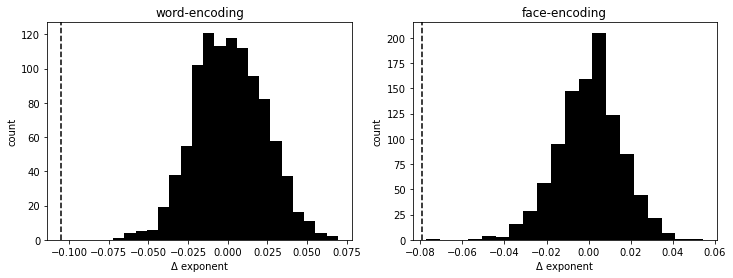

word-encoding: -0.10503906089771942
face-encoding: -0.07911433805996237


In [5]:
# plot results for both trial types

# plot
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))

ax1.hist(diff_w, bins=20, color='k')
ax1.axvline(true_diff_w, color='k', linestyle='--')
ax1.set_title('word-encoding')

ax2.hist(diff_f, bins=20, color='k')
ax2.axvline(true_diff_f, color='k', linestyle='--')
ax2.set_title('face-encoding')

for ax in [ax1, ax2]:
    ax.set_xlabel('\u0394 exponent')
    ax.set_ylabel('count')
plt.show()

print(f"word-encoding: {true_diff_w}")
print(f"face-encoding: {true_diff_f}")


### include material as additional level

In [ ]:
# # perform hierarchical bootstrap - include material as additional level

# # time it 
# t_start = time()

# # successful trials only
# df = results[results['memory']=='hit']
# n_samples = len(df)

# # get levels
# epochs = df['epoch'].unique()
# materials = df['material'].unique()

# # loop through iterations
# diff = np.zeros(n_iterations)
# for ii in range(n_iterations):
#     # display progress
#     print(f"Iteration {ii+1}/{n_iterations}")

#     # resample level 1: epoch
#     epochs = np.random.choice(epochs, size=n_samples)
#     # resample level 2: material
#     materials = np.random.choice(materials, size=n_samples)
#     # resample level 3: patient
#     patients = np.random.choice(patients, size=n_samples)

#     # resample level 4: channel, and get data
#     value = np.zeros(n_samples)
#     for i_sample, (epoch, material, patient) in enumerate(zip(epochs, materials, patients)):
#         # resample level 4: channel
#         channel = np.random.choice(n_channels[patient], size=1)[0]

#         # get data
#         value[i_sample] = df.loc[(df['epoch']==epoch) & (df['material']==material) \
#             & (df['patient']==patient) & (df['chan_idx']==channel), var].values[0]

#     # compute difference between resampled experimental conditions
#     diff[i_iteration] = np.nanmean(value[len(value)//2:]) - np.nanmean(value[:len(value)//2])
#     print(diff[i_iteration])

# # plot
# fig, ax = plt.subplots(figsize=(6,4))
# ax.hist(diff, bins=20, color='k')
# ax.axvline(true_diff, color='k', linestyle='--')
# ax.set_xlabel('exponent difference')
# ax.set_ylabel('count')
# ax.set_title('Resampled exponent')
# plt.show()

# # print time
# print(f"Resampling completed in {time() - t_start :0.1f} s")